In [ ]:
#Import Libraries & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Optional graph library
try:
    import networkx as nx
    NETWORKX_AVAILABLE = True
except ImportError:
    NETWORKX_AVAILABLE = False
    print("NetworkX not installed. Graph visualization will be skipped.")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")


All libraries imported successfully


In [ ]:
#Data Loading & Basic EDA
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')
print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe())


Shape: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

None

,bytes_in,bytes_out,response.code,dst_port
count,2.820000e+02,2.820000e+02,282.0,282.0
mean,1.199390e+06,8.455429e+04,200.0,443.0
std,4.149312e+06,2.549279e+05,0.0,0.0
min,4.000000e+01,4.400000e+01,200.0,443.0
25%,5.381500e+03,1.114200e+04,200.0,443.0
50%,1.318200e+04,1.379950e+04,200.0,443.0
75%,3.083300e+04,2.627950e+04,200.0,443.0
max,2.520779e+07,1.561220e+06,200.0,443.0


In [ ]:
#Data Cleaning and Preprocessing
print("Missing values:\n", df.isnull().sum())
duplicates = df.duplicated().sum()
print("Duplicate rows:", duplicates)
df_clean = df.drop_duplicates().copy()

for col in ['creation_time', 'end_time', 'time']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col])

if 'src_ip_country_code' in df_clean.columns:
    df_clean['src_ip_country_code'] = df_clean['src_ip_country_code'].str.upper()

print("Cleaned shape:", df_clean.shape)


Missing values:
 bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64
Duplicate rows: 0
Cleaned shape: (282, 16)


In [ ]:
#Feature Engineering
df_clean['session_duration'] = (df_clean['end_time'] - df_clean['creation_time']).dt.total_seconds()
df_clean['avg_packet_size'] = (df_clean['bytes_in'] + df_clean['bytes_out']) / 2
df_clean['transfer_ratio'] = df_clean['bytes_out'] / (df_clean['bytes_in'] + 1)
df_clean['hour_of_day'] = df_clean['creation_time'].dt.hour
df_clean['is_suspicious'] = (df_clean['detection_types'] == 'waf_rule').astype(int)
print("Feature engineering completed.")


Feature engineering completed.


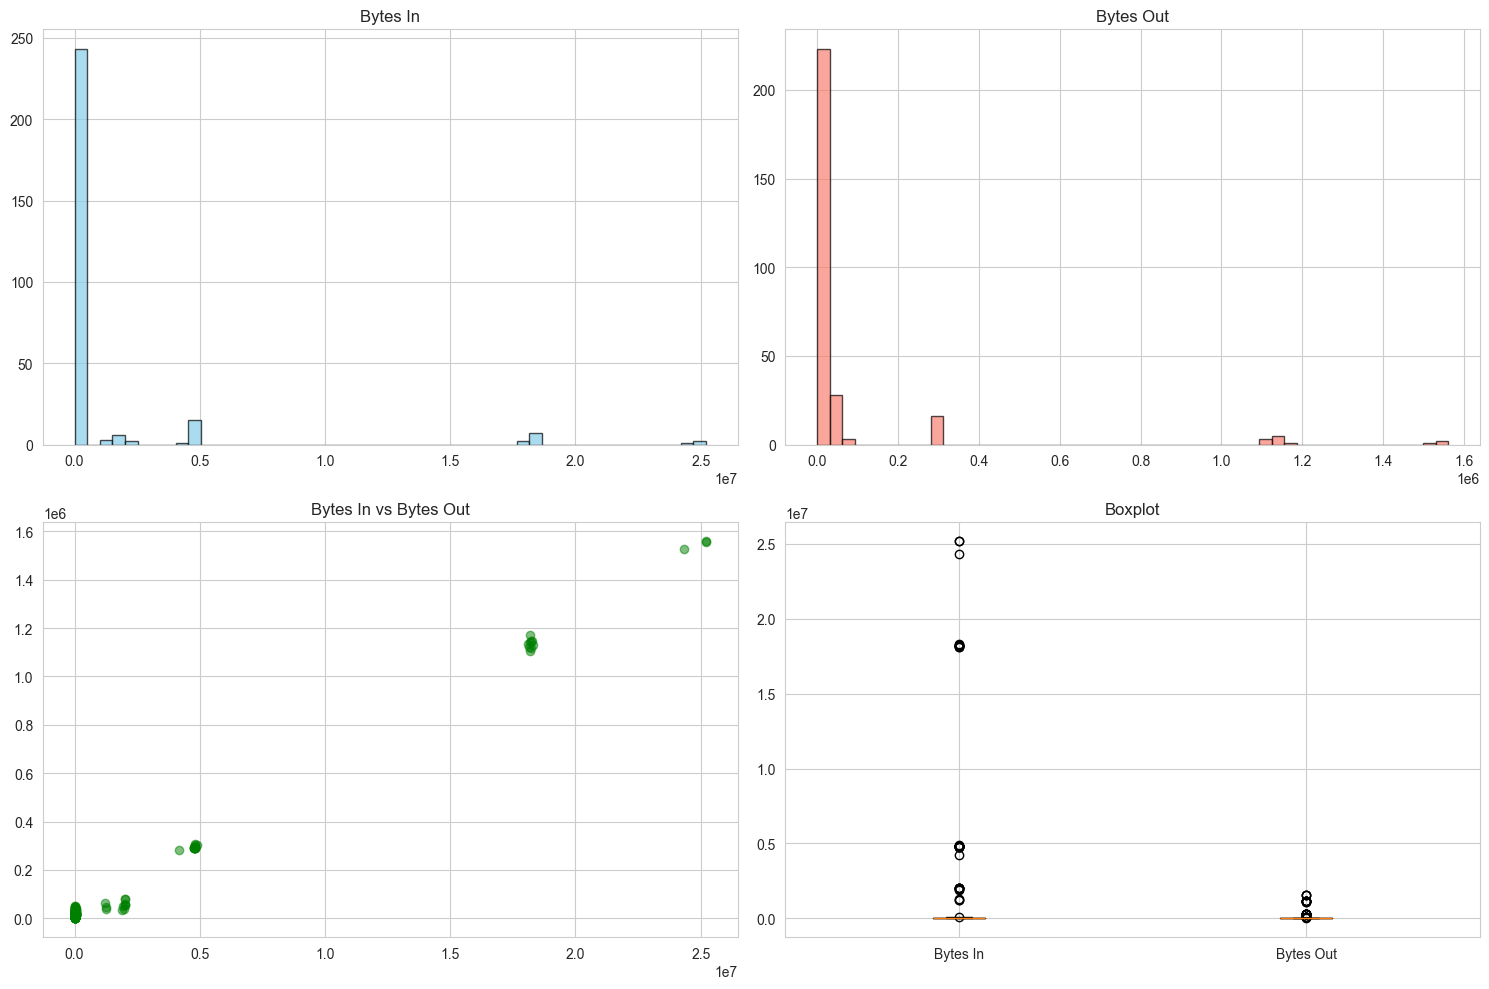

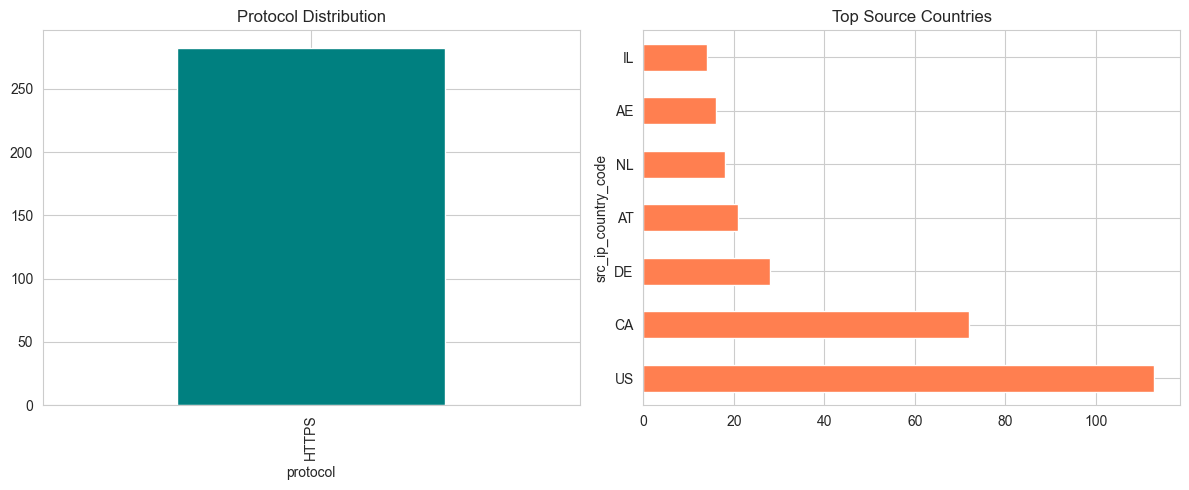

In [ ]:
#Exploratory Data Analysis (Bytes, Protocol, Country)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].hist(df_clean['bytes_in'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Bytes In')
axes[0, 1].hist(df_clean['bytes_out'], bins=50, color='salmon', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Bytes Out')
axes[1, 0].scatter(df_clean['bytes_in'], df_clean['bytes_out'], alpha=0.5, c='green')
axes[1, 0].set_title('Bytes In vs Bytes Out')
axes[1, 1].boxplot([df_clean['bytes_in'], df_clean['bytes_out']], labels=['Bytes In', 'Bytes Out'])
axes[1, 1].set_title('Boxplot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
protocol_counts = df_clean['protocol'].value_counts()
plt.subplot(1, 2, 1)
protocol_counts.plot(kind='bar', color='teal')
plt.title('Protocol Distribution')
plt.subplot(1, 2, 2)
country_counts = df_clean['src_ip_country_code'].value_counts().head(10)
country_counts.plot(kind='barh', color='coral')
plt.title('Top Source Countries')
plt.tight_layout()
plt.show()


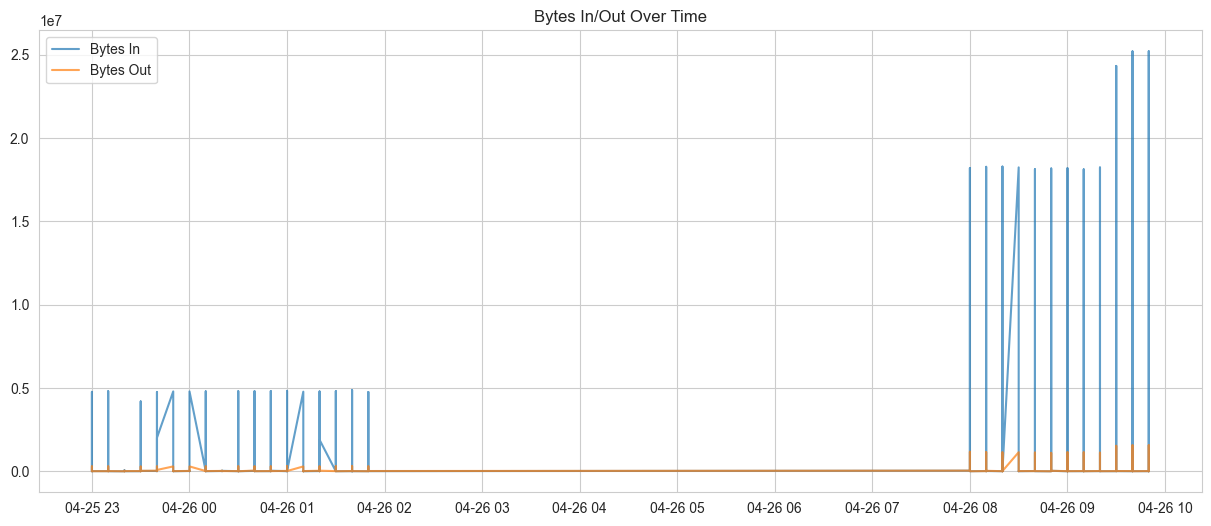

In [ ]:
#Time Series Visualization
plt.figure(figsize=(15,6))
df_clean_sorted = df_clean.sort_values('creation_time')
plt.plot(df_clean_sorted['creation_time'], df_clean_sorted['bytes_in'], label='Bytes In', alpha=0.7)
plt.plot(df_clean_sorted['creation_time'], df_clean_sorted['bytes_out'], label='Bytes Out', alpha=0.7)
plt.legend()
plt.title('Bytes In/Out Over Time')
plt.show()


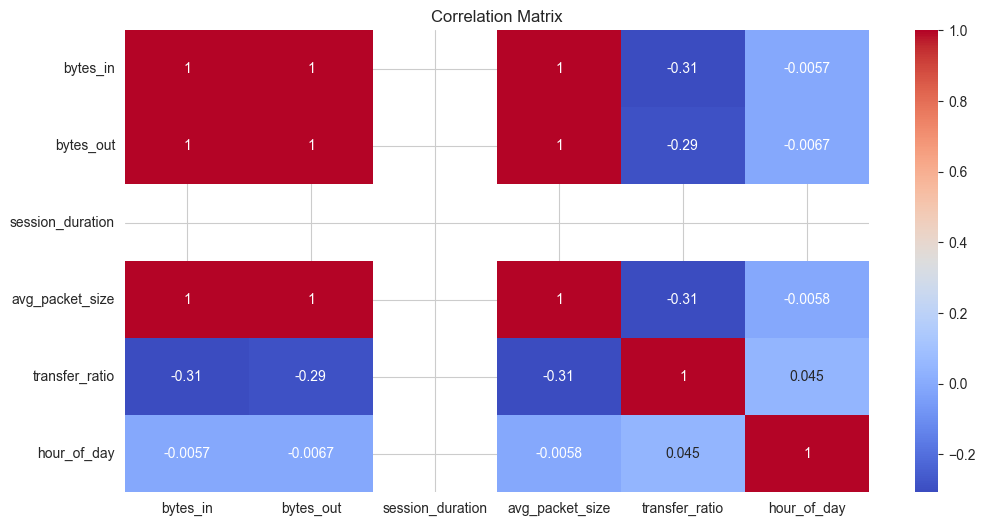

In [ ]:
#Correlation Matrix
numeric_cols = ['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size', 'transfer_ratio', 'hour_of_day']
corr = df_clean[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
#Transformation for Machine Learning
scaler = StandardScaler()
for col in ['bytes_in', 'bytes_out', 'session_duration']:
    df_clean[f'scaled_{col}'] = scaler.fit_transform(df_clean[[col]])

encoder = OneHotEncoder(sparse_output=False)
encoded_countries = encoder.fit_transform(df_clean[['src_ip_country_code']].fillna('XX'))
encoded_df = pd.DataFrame(encoded_countries, columns=encoder.get_feature_names_out(['src_ip_country_code']), index=df_clean.index)
df_features = pd.concat([df_clean, encoded_df], axis=1)

print("Transformation for machine learning completed.")

Transformation for machine learning completed.


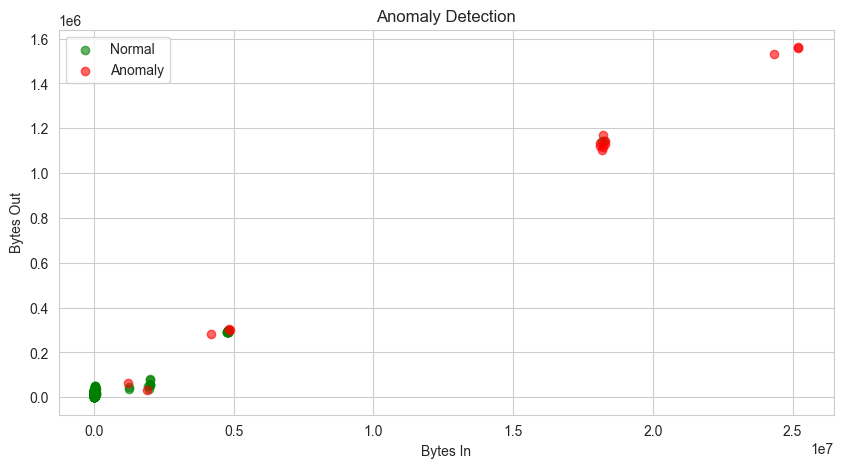

In [ ]:
#Anomaly Detection (Isolation Forest)
X_anomaly = df_clean[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_clean['anomaly'] = iso_forest.fit_predict(X_anomaly)
df_clean['anomaly_label'] = df_clean['anomaly'].map({-1: 'Anomaly', 1: 'Normal'})
plt.figure(figsize=(10,5))
for l, c in zip(['Normal', 'Anomaly'], ['green', 'red']):
    m = df_clean['anomaly_label'] == l
    plt.scatter(df_clean.loc[m,'bytes_in'], df_clean.loc[m, 'bytes_out'], c=c, label=l, alpha=0.6)
plt.xlabel('Bytes In')
plt.ylabel('Bytes Out')
plt.title('Anomaly Detection')
plt.legend()
plt.show()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5223 - loss: 0.6754 - val_accuracy: 1.0000 - val_loss: 0.6228
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.6278 - val_accuracy: 1.0000 - val_loss: 0.5618
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.5668 - val_accuracy: 1.0000 - val_loss: 0.5027
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.5130 - val_accuracy: 1.0000 - val_loss: 0.4495
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.4523 - val_accuracy: 1.0000 - val_loss: 0.3822
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.3741 - val_accuracy: 1.0000 - val_loss: 0.3007
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.2838 - val_accuracy: 1.0000 - val_loss: 0.2139
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.1947 - val_accuracy: 1.0000 - val_los

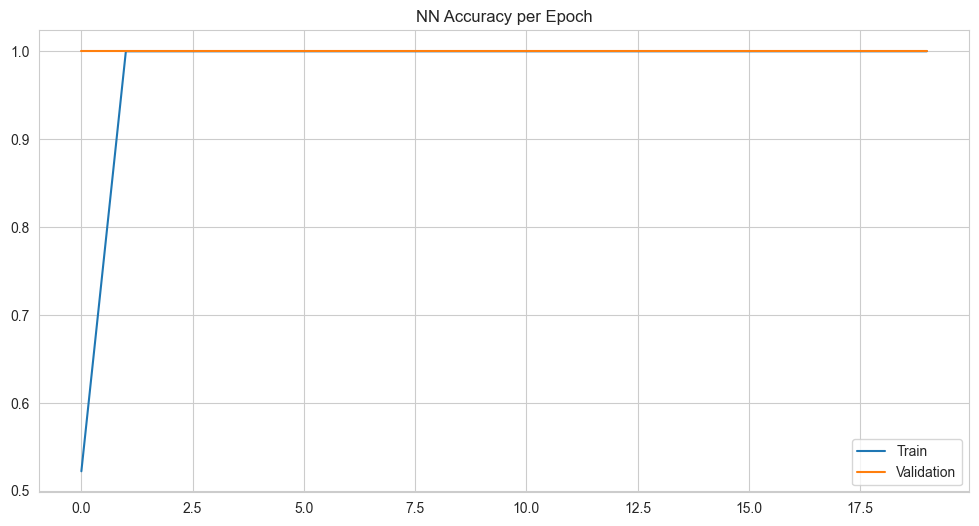

In [ ]:
#Neural Network Model
from tensorflow.keras.utils import set_random_seed

set_random_seed(42)
X_nn = df_clean[['bytes_in', 'bytes_out']].values
y_nn = df_clean['is_suspicious'].values
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.3, random_state=42)
scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_scaled = scaler_nn.transform(X_test_nn)

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train_nn, epochs=20, batch_size=16, validation_split=0.2, verbose=1)
loss, acc = model.evaluate(X_test_scaled, y_test_nn, verbose=0)
print("Test Accuracy: {:.2f}%".format(acc * 100))

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('NN Accuracy per Epoch')
plt.legend()
plt.show()


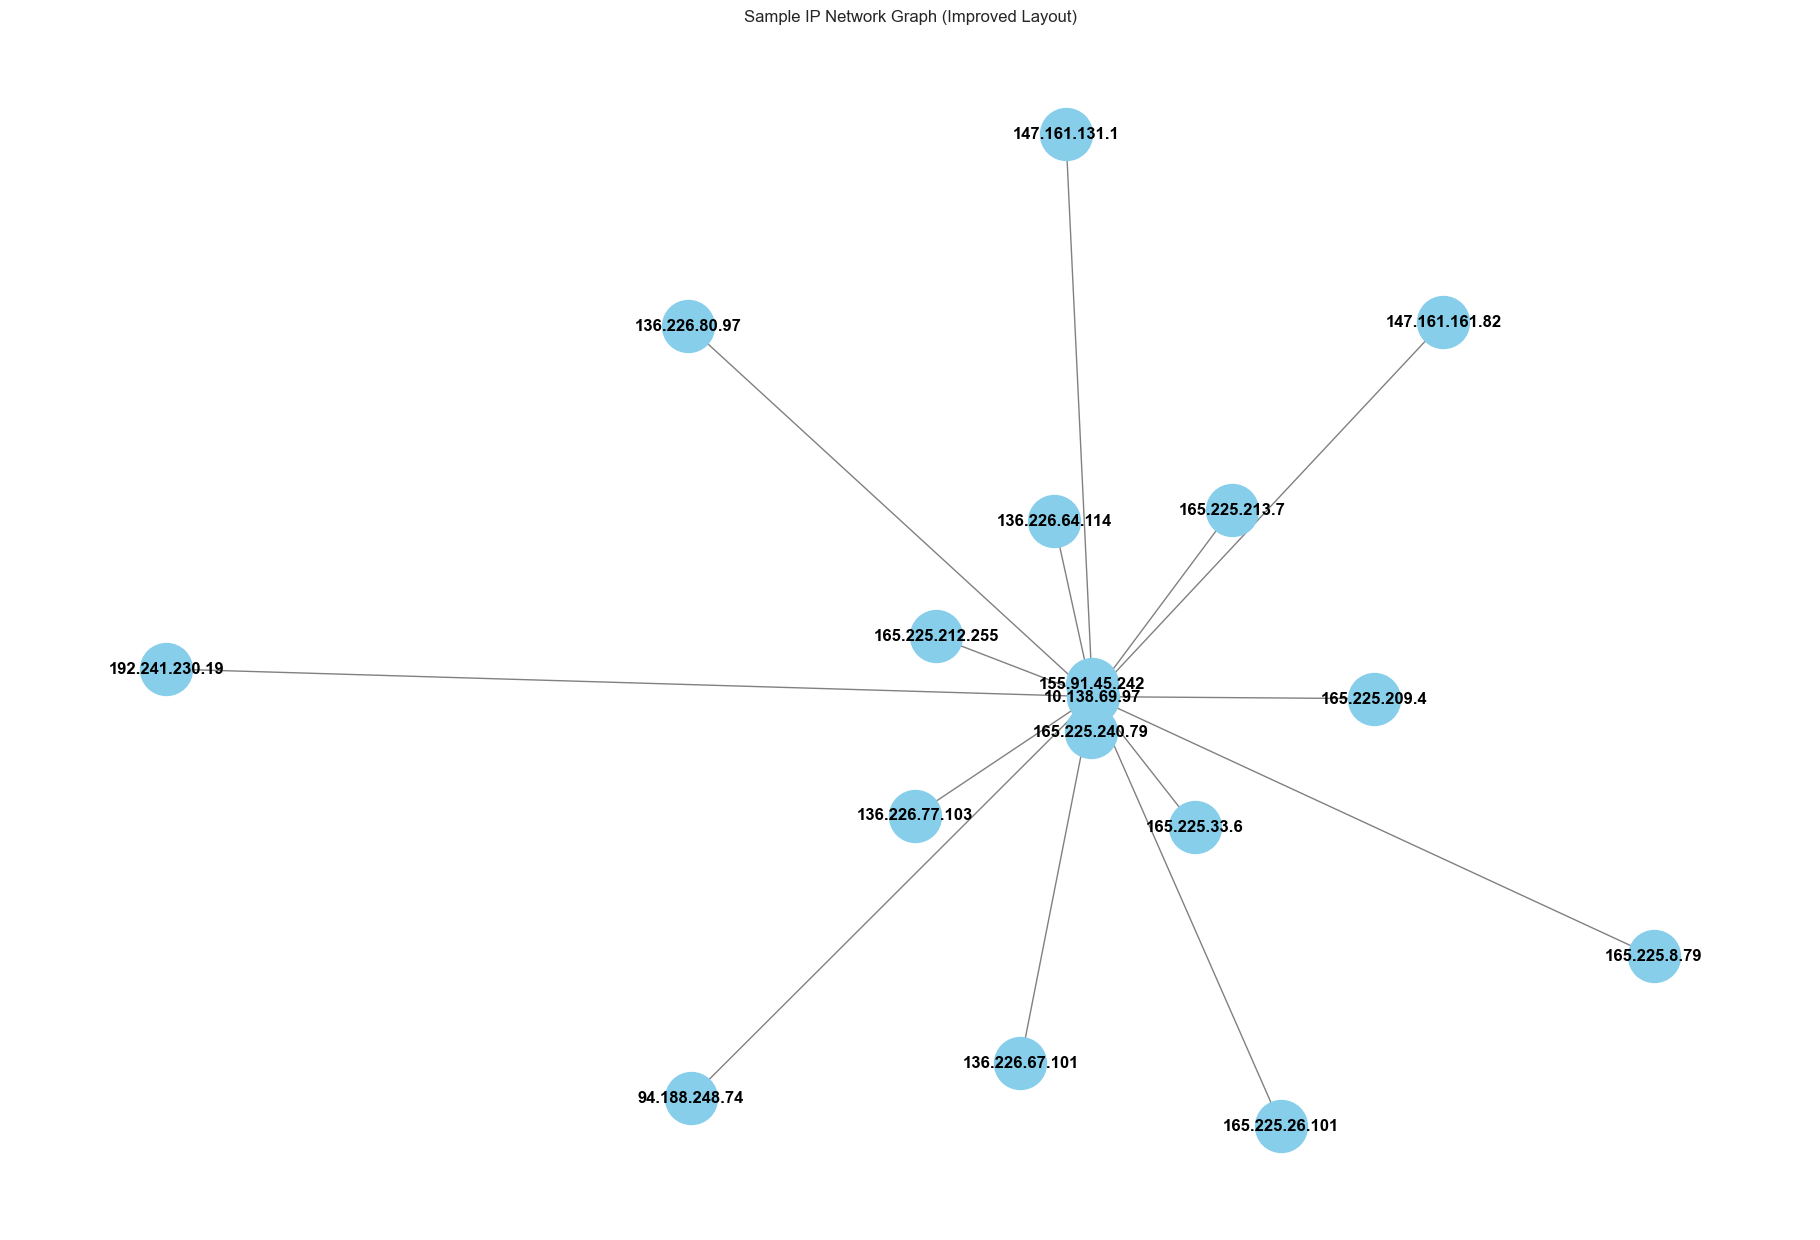

In [ ]:
#Improved Network Graph Visualization (Spring Layout)

if NETWORKX_AVAILABLE:
    G = nx.Graph()
    sample_data = df_clean.head(50)

    for _, row in sample_data.iterrows():
        G.add_edge(row['src_ip'], row['dst_ip'], weight=row['bytes_in'])

    plt.figure(figsize=(18, 12))

    pos = nx.spring_layout(G, k=1.2, iterations=200)   # Spread nodes more

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='skyblue',
        edge_color='gray',
        node_size=1400,
        font_size=12,
        font_weight='bold'
    )

    plt.title('Sample IP Network Graph (Improved Layout)')
    plt.show()

else:
    print("NetworkX not available, skipping graph visualization.")



In [ ]:
#Summary & Insights
total = len(df_clean)
top_countries = df_clean['src_ip_country_code'].value_counts().head(5)
print(f"Total clean records: {total}")
print(f"Top threat countries: {dict(top_countries)}")
print(f"Suspicious activities: {df_clean['is_suspicious'].sum()}")

print("\n  Recommendations:")
print("- Monitor frequent suspicious countries and proactively block high-risk source IPs.")
print("- Investigate detected anomalies with detailed root cause analysis.")
print("- Enable automated real-time alerts for unusual traffic volume or session duration.")
print("- Strengthen authentication: Implement multi-factor authentication (MFA) for all accounts.")
print("- Patch and update all systems and applications regularly to close security gaps.")
print("- Conduct regular cybersecurity awareness training for all users with access.")
print("- Isolate accounts and devices repeatedly linked to suspicious activity for deeper investigation.")
print("- Centralize log management for comprehensive threat detection and historical analysis.")
print("- Retain logs securely with strong encryption and proper access controls for forensic readiness.")
print("- Regularly review and enhance your incident response plan, including simulations of new threat scenarios.")
print("- Integrate external threat intelligence feeds to stay updated on emerging attack vectors.")
print("- Segment critical networks to minimize the impact of compromised assets.")



Total clean records: 282
Top threat countries: {'US': np.int64(113), 'CA': np.int64(72), 'DE': np.int64(28), 'AT': np.int64(21), 'NL': np.int64(18)}
Suspicious activities: 282

  Recommendations:
- Monitor frequent suspicious countries and proactively block high-risk source IPs.
- Investigate detected anomalies with detailed root cause analysis.
- Enable automated real-time alerts for unusual traffic volume or session duration.
- Strengthen authentication: Implement multi-factor authentication (MFA) for all accounts.
- Patch and update all systems and applications regularly to close security gaps.
- Conduct regular cybersecurity awareness training for all users with access.
- Isolate accounts and devices repeatedly linked to suspicious activity for deeper investigation.
- Centralize log management for comprehensive threat detection and historical analysis.
- Retain logs securely with strong encryption and proper access controls for forensic readiness.
- Regularly review and enhance you